In [8]:
import pandas as pd
from sklearn.inspection import permutation_importance
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor
import numpy as np
from genetic_selection import GeneticSelectionCV
import tensorflow as tf
from imblearn.over_sampling import SMOTE
import cufflinks as cfs
from numpy.random import permutation
import scipy.stats as sts
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score,roc_curve
from sklearn.preprocessing import MinMaxScaler,LabelEncoder
from keras import Sequential, regularizers, optimizers
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.feature_selection import f_regression,mutual_info_classif
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import KFold
import time

In [2]:
load_dataa=pd.read_csv("Bot_ISCX.csv")
# load_dataa=load_dataa.drop(['Flow ID', ' Source IP', ' Source Port', ' Destination IP',
#        ' Destination Port', ' Protocol', ' Timestamp'],axis=1)
print('Raw dataset',load_dataa.shape)
label_encode=LabelEncoder()
y_load=label_encode.fit_transform(load_dataa["Label"])
y_=pd.DataFrame(y_load)
y_.columns=['Label']
x_=load_dataa.drop('Label', axis=1)
class_00=y_[y_['Label']==0]
class_11=y_[y_['Label']==1]
print('No of Botnet data from Raw Dataset', class_11.shape)
print('No of Benign data from Raw Dataset', class_00.shape)

Raw dataset (190911, 78)
No of Botnet data from Raw Dataset (1956, 1)
No of Benign data from Raw Dataset (188955, 1)


In [3]:
labels = ['Bening', 'Botnet']
count_bot=y_[y_.Label==1]
count_benign=y_[y_.Label==0]
counts = [count_benign.shape[0],count_bot.shape[0]]
state={'Labels':labels,'State':counts}
show_datasts=pd.DataFrame.from_dict(state)
cfs.set_config_file(sharing='Public',theme='polar',offline=True)
benign_bot_status=show_datasts.set_index('Labels')
benign_bot_status.iplot(kind='bar',color=['blue','red'],xTitle="Label",yTitle="No of Datasets",dimensions=(600,450),
                        title='Raw Dataset (Imbalanced)',bargap=0.2,sortbars=True)
balance_check=(count_benign.shape[0]/(count_benign.shape[0]+count_bot.shape[0]))*100
print('Ration of Bot to benign: %.2f'%balance_check,'%')

Ration of Bot to benign: 98.98 %


In [4]:
x_y_join=pd.concat([x_,y_],join = 'outer', axis = 1)
x_y_join.drop_duplicates(inplace=True)

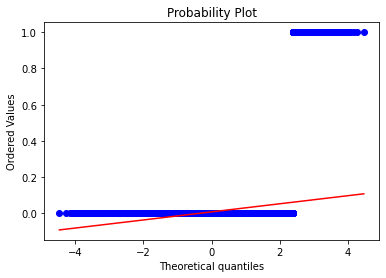

In [5]:
# check data Normality
xx=x_y_join.drop('Label', axis=1)
normality_check=sts.probplot(x_y_join['Label'],dist="norm",plot=plt)
plt.show()

In [6]:
#### function to load and split data into Training, validation and Testing
def load_dataset(filename):
    xx=filename.drop('Label',axis=1)
    yy=filename['Label']
    return xx,yy
xx,yy=load_dataset(x_y_join)
# x_randomed=x.iloc[permutation(x.index)]
# y_random=y.iloc[permutation(y.index)]
# y_random.index=x_randomed.index
xb_train,xb_test,yb_train,yb_test=train_test_split(xx,yy,test_size=0.09999,random_state=42)
xbb_train,xbb_val,ybb_train,ybb_val=train_test_split(xb_train,yb_train,test_size=0.1112,random_state=1)
print("Train Data",xbb_train.shape, ybb_train.shape)
print("Validation Data",xbb_val.shape, ybb_val.shape)
print("Test", xb_test.shape, yb_test.shape)

Train Data (140817, 77) (140817,)
Validation Data (17618, 77) (17618,)
Test (17603, 77) (17603,)


In [11]:
# feature selection
# estimators = linear_model.LinearRegression()
estimators = DecisionTreeClassifier()
#estimators = RandomForestRegressor()
#estimators = MLPRegressor()
t1=time.time()
report = pd.DataFrame()
nofeats = [] 
chosen_feats = [] 
cvscore = [] 
# feature selection
def select_features(xbb_train, ybb_train,xb_test,xbb_val):
#     selectedb_f.fit_transform(xbb_train,ybb_train)
    print("Estimator : ", estimators )
    for i in range(1,xbb_train.shape[1]):  
        selector = GeneticSelectionCV(estimators,cv = 5,verbose = 1,scoring="accuracy", max_features = i,n_population = 20,
                                      crossover_proba = 0.5,mutation_proba = 0.2,n_generations = 5,
                                      crossover_independent_proba=0.5,mutation_independent_proba=0.2,tournament_size = 5,
                                      n_gen_no_change=5,caching=True,n_jobs=-1)
    selector = selector.fit(xbb_train,ybb_train)
    genfeats = xbb_train.columns[selector.support_]
    genfeats = list(genfeats)
    print("Number of Feats: {}, Fitness scores : {} " .format(selector.n_features_, round(selector.generation_scores_[-1], 3)))
    cv_score = selector.generation_scores_[-1]
    nofeats.append(len(genfeats)) 
    chosen_feats.append(genfeats) 
    cvscore.append(cv_score)
    report["No of Feats"] = nofeats
    report["Chosen Feats"] = chosen_feats
    report["Scores"] = cvscore
   #GA feature selection Time 
    t2=time.time()
    t_polyfit = float(t2-t1)
    print("Time taken: {} seconds".format(t_polyfit))
    xbb_trainsele_fs2=selector.transform(xbb_train)
    xbb_testsele_fs2=selector.transform(xb_test)
    xbb_valsele_fs2=selector.transform(xbb_val)
    return xbb_trainsele_fs2,xbb_testsele_fs2,xbb_valsele_fs2,selector
# split dataset into training,testing and validation
xbb_trainsele_fs1,xbb_testsele_fs1,xbb_valsele_fs1,selector=select_features(xbb_train,ybb_train,xb_test,xbb_val)
print('X_Training Value: ',xbb_trainsele_fs1.shape)
print('Y_training set: ',ybb_train.shape)
norm_MINMAX=MinMaxScaler(feature_range=(0,1))
norm_MINMAX.fit(xbb_trainsele_fs1)
xbb_trainsele_fs=norm_MINMAX.transform(xbb_trainsele_fs1)
xbb_valsele_fs=norm_MINMAX.transform(xbb_valsele_fs1)
xbb_testsele_fs=norm_MINMAX.transform(xbb_testsele_fs1)
# Measuring all the features
# for i in range(len(selected_f.scores_)):
#     print('feature: %d, Score: %f'% (i,selected_f.scores_[i]))
#     plt.bar([i for i in range(len(selected_f.scores_))],selected_f.scores_)
#     plt.show

Estimator :  DecisionTreeClassifier()
Selecting features with genetic algorithm.
gen	nevals	avg                               	std                               	min                            	max                               
0  	20    	[  0.998441  40.6        0.00013 ]	[  0.001828  24.175194   0.000052]	[ 0.991833  3.        0.000052]	[  0.999546  75.         0.000231]
1  	14    	[  0.999413  60.85       0.000102]	[  0.000182  10.706423   0.000027]	[  0.998786  36.         0.000061]	[  0.999546  75.         0.00017 ]
2  	12    	[  0.999519  53.9        0.000096]	[ 0.000027  6.533758  0.000018]   	[  0.999446  39.         0.000061]	[  0.999546  75.         0.00014 ]
3  	9     	[  0.999513  51.7        0.0001  ]	[ 0.000088  2.325941  0.000031]   	[  0.999148  45.         0.000066]	[  0.999574  58.         0.000224]
4  	9     	[  0.999541  52.3        0.000098]	[ 0.000042  2.91719   0.000029]   	[  0.999403  47.         0.000066]	[  0.999595  58.         0.000173]
5  	8     	[  0.999

In [12]:
def Bbalance_NN_model():
    db_model=Sequential()
    db_model.add(Dense(8,input_shape=(xbb_trainsele_fs.shape[1],),activation='relu'))
    db_model.add(Dense(20,activation='relu'))
    db_model.add(Dense(20,activation='relu'))
    db_model.add(Dense(20,activation='relu'))
    db_model.add(Dense(1,activation='sigmoid'))
    optimizer1=optimizers.RMSprop(learning_rate=0.0001)
    db_model.compile(optimizer=optimizer1,loss="binary_crossentropy",metrics=["accuracy"])
    return db_model
db_model=KerasClassifier(build_fn=Bbalance_NN_model)

<ipython-input-12-2ecfabd06eb8>:11: DeprecationWarning:

KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.



In [13]:
# Train model
Train_model_bbalance = db_model.fit(xbb_trainsele_fs, ybb_train, validation_data=
                                             (xbb_valsele_fs, ybb_val),batch_size=250, epochs=100)
Train_model_bbalance

Epoch 1/100
564/564 [==============================] - 3s 3ms/step - loss: 0.5230 - accuracy: 0.9839 - val_loss: 0.3122 - val_accuracy: 0.9926
Epoch 2/100
564/564 [==============================] - 1s 3ms/step - loss: 0.1377 - accuracy: 0.9917 - val_loss: 0.0395 - val_accuracy: 0.9926
Epoch 3/100
564/564 [==============================] - 1s 2ms/step - loss: 0.0393 - accuracy: 0.9917 - val_loss: 0.0326 - val_accuracy: 0.9926
Epoch 4/100
564/564 [==============================] - 1s 2ms/step - loss: 0.0348 - accuracy: 0.9917 - val_loss: 0.0285 - val_accuracy: 0.9926
Epoch 5/100
564/564 [==============================] - 1s 2ms/step - loss: 0.0308 - accuracy: 0.9917 - val_loss: 0.0247 - val_accuracy: 0.9926
Epoch 6/100
564/564 [==============================] - 1s 3ms/step - loss: 0.0276 - accuracy: 0.9917 - val_loss: 0.0220 - val_accuracy: 0.9926
Epoch 7/100
564/564 [==============================] - 1s 2ms/step - loss: 0.0251 - accuracy: 0.9917 - val_loss: 0.0198 - val_accuracy: 0.9926

Epoch 58/100
564/564 [==============================] - 1s 3ms/step - loss: 0.0109 - accuracy: 0.9973 - val_loss: 0.0082 - val_accuracy: 0.9978
Epoch 59/100
564/564 [==============================] - 2s 3ms/step - loss: 0.0108 - accuracy: 0.9973 - val_loss: 0.0081 - val_accuracy: 0.9978
Epoch 60/100
564/564 [==============================] - 2s 3ms/step - loss: 0.0107 - accuracy: 0.9974 - val_loss: 0.0080 - val_accuracy: 0.9978
Epoch 61/100
564/564 [==============================] - 2s 3ms/step - loss: 0.0106 - accuracy: 0.9974 - val_loss: 0.0079 - val_accuracy: 0.9981
Epoch 62/100
564/564 [==============================] - 1s 3ms/step - loss: 0.0105 - accuracy: 0.9974 - val_loss: 0.0078 - val_accuracy: 0.9981
Epoch 63/100
564/564 [==============================] - 2s 3ms/step - loss: 0.0104 - accuracy: 0.9975 - val_loss: 0.0077 - val_accuracy: 0.9981
Epoch 64/100
564/564 [==============================] - 2s 4ms/step - loss: 0.0104 - accuracy: 0.9978 - val_loss: 0.0077 - val_accuracy:

In [14]:
DNN_Model_bbalance = db_model.predict(xbb_testsele_fs)
DNNM_Analysis_bb = pd.DataFrame(classification_report(yb_test,DNN_Model_bbalance, output_dict=True)).transpose()
DNNM_Analysis_bb

551/551 [==============================] - 1s 1ms/step


,precision,recall,f1-score,support
0,0.999027,0.999599,0.999313,17465.000000
1,0.945312,0.876812,0.909774,138.000000
accuracy,0.998637,0.998637,0.998637,0.998637
macro avg,0.972170,0.938205,0.954544,17603.000000
weighted avg,0.998606,0.998637,0.998611,17603.000000


In [15]:
Confusion_matxmlp=pd.DataFrame(confusion_matrix(yb_test,DNN_Model_bbalance),index=["Actual Benign","Actual Bot"],
                               columns=("Prediction Benign", "Prediction Bot"))
print(Confusion_matxmlp)
print('----------------------------------------------------------------------')

               Prediction Benign  Prediction Bot
Actual Benign              17458               7
Actual Bot                    17             121
----------------------------------------------------------------------


In [17]:
Acc_statemlp=accuracy_score(yb_test,DNN_Model_bbalance)
print('Accuracy of the Model= %.2f '%(Acc_statemlp*100))
print('----------------------------------------------------------------------')
print('----------------------------------------------------------------------')

Accuracy of the Model= 99.86 
----------------------------------------------------------------------
----------------------------------------------------------------------


## Balancing Class, Which is Bot to Benign Ratio 

In [18]:
oversample=SMOTE(random_state=42,sampling_strategy=0.4)
Xx_,Yy_=oversample.fit_resample(x_,y_)
data_balance=pd.concat([Xx_,Yy_],join = 'outer', axis = 1)
print('The data dimension after balanced',data_balance.shape)
data_balance.drop_duplicates(inplace=True)
print('The data dimension after duplicate removed',data_balance.shape)
dups=data_balance.duplicated()
print('Data Duplication checked and it verifies, Data duplication present: ',dups.any())
class_00=data_balance[data_balance['Label']==0]
class_11=data_balance[data_balance['Label']==1]
# print("total class of 1 and 0:",test_over['Label'].value_counts())# plot the count after under-sampeling
print('class 0:', class_00.shape)
print('class 1:', class_11.shape)

The data dimension after balanced (264537, 78)
The data dimension after duplicate removed (228626, 78)
Data Duplication checked and it verifies, Data duplication present:  False
class 0: (174601, 78)
class 1: (54025, 78)


In [19]:
labels = ['Benign', 'Botnet']
count_bot=data_balance[data_balance.Label==1]
count_benign=data_balance[data_balance.Label==0]
counts = [count_benign.shape[0],count_bot.shape[0]]
state={'Labels':labels,'State':counts}
show_datasts=pd.DataFrame.from_dict(state)
cfs.set_config_file(sharing='Public',theme='polar',offline=True)
benign_bot_status=show_datasts.set_index('Labels')
benign_bot_status.iplot(kind='bar',colors=['blue'],bestfit_colors=['black'],xTitle="Label",yTitle="No of Datasets",dimensions=(600,450),
                        title='Dataset after balanced',bargap=0.2,sortbars=True)
balance_check=(count_benign.shape[0]/(count_benign.shape[0]+count_bot.shape[0]))*100
print('Ration of Bot to benign: %.2f'%balance_check,'%')

Ration of Bot to benign: 76.37 %


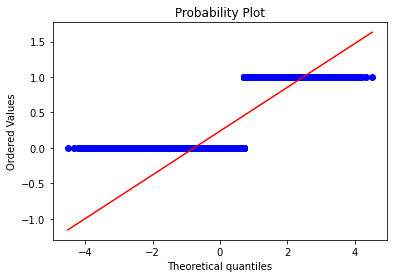

In [20]:
# check data Normality
xx=data_balance.drop('Label', axis=1)
normality_check=sts.probplot(data_balance['Label'],dist="norm",plot=plt)
plt.show()

In [21]:
#### function to load and split data into Training, validation and Testing
def load_dataset(filename):
    x=filename.drop('Label',axis=1)
    y=filename['Label']
    return x,y
x,y=load_dataset(data_balance)
# x_randomed=x.iloc[permutation(x.index)]
# y_random=y.iloc[permutation(y.index)]
# y_random.index=x_randomed.index
xx_train,x_test,yy_train,y_test=train_test_split(x,y,test_size=0.09999,random_state=42)
# x_train,x_val,y_train,y_val=train_test_split(xx_train,yy_train,test_size=0.05263,random_state=1)
kf=KFold(n_splits=9,random_state=42, shuffle=True)
splits=kf.split(xx_train)
for t_index,dev_index in splits:
    x_train,x_val=xx_train.iloc[t_index],xx_train.iloc[dev_index]
    y_train,y_val=yy_train.iloc[t_index],yy_train.iloc[dev_index]
print("Train Data",x_train.shape, y_train.shape)
print("Validation Data",x_val.shape, y_val.shape)
print("Test", x_test.shape, y_test.shape)

Train Data (182903, 77) (182903,)
Validation Data (22862, 77) (22862,)
Test (22861, 77) (22861,)


# Feature selection 
Is based on the score function "f_regression". The f_regression ranks features in the same order based on the positive corelation of features with the target value: {x->y} x is independent variable and y is dependent variable. 
The correlation between each regressor and the target is computed via r_regression as:
E[(X[:, i] - mean(X[:, i])) * (y - mean(y))] / (std(X[:, i]) * std(y))

In [22]:
# feature selection
# estimators = linear_model.LinearRegression()
estimators = DecisionTreeClassifier()
# estimators = RandomForestRegressor()
#estimators = MLPRegressor()
t1=time.time()
report = pd.DataFrame()
nofeats = [] 
chosen_feats = [] 
cvscore = [] 
def select_features(x_train, y_train,x_test,x_val):
   # selected_f=SelectKBest(score_func=f_regression,k=60)
    #selected_f.fit_transform(x_train,y_train)
    print("Estimator : ", estimators )
    for i in range(1,x_train.shape[1]):  
        selector = GeneticSelectionCV(estimators,cv = 5,verbose = 1,scoring="accuracy", max_features = i,n_population = 20,
                                      crossover_proba = 0.5,mutation_proba = 0.2,n_generations = 5,
                                      crossover_independent_proba=0.5,mutation_independent_proba=0.2,tournament_size = 5,
                                      n_gen_no_change=5,caching=True,n_jobs=-1)
    selector = selector.fit(x_train, y_train)
    genfeats = x_train.columns[selector.support_]
    genfeats = list(genfeats)
    print("Number of Feats: {}, Fitness scores : {} " .format(selector.n_features_, round(selector.generation_scores_[-1], 3)))
    cv_score = selector.generation_scores_[-1]
    nofeats.append(len(genfeats)) 
    chosen_feats.append(genfeats) 
    cvscore.append(cv_score)
    report["No of Features selected"] = nofeats
    report["Chosen Feats"] = chosen_feats
    report["Scores"] = cvscore
   #GA feature selection Time 
    t2=time.time()
    t_polyfit = float(t2-t1)
    print("Time taken: {} seconds".format(t_polyfit))
    #Ranking
    x_trainsele_fs2=selector.transform(x_train)
    x_testsele_fs2=selector.transform(x_test)
    x_valsele_fs2=selector.transform(x_val)
    return x_trainsele_fs2,x_testsele_fs2,x_valsele_fs2,selector
# split dataset into training,testing and validation
x_trainsele_fs1,x_testsele_fs1,x_valsele_fs1,selector=select_features(x_train,y_train,x_test,x_val)
# Measuring all the features
# for i in range(len(selector.scores_)):
#     print('feature: %d, Score: %f'% (i,selector.scores_[i]))
#     plt.bar([i for i in range(len(selector.scores_))],selector.scores_)
#     plt.show

Estimator :  DecisionTreeClassifier()
Selecting features with genetic algorithm.
gen	nevals	avg                               	std                               	min                            	max                               
0  	20    	[  0.986874  34.4        0.000368]	[  0.022137  21.866413   0.000329]	[ 0.90297   3.        0.000081]	[  0.998704  75.         0.001479]
1  	11    	[  0.996737  49.6        0.000195]	[  0.003939  18.084247   0.000097]	[  0.981487  12.         0.000081]	[  0.998704  75.         0.000524]
2  	10    	[  0.998622  51.45       0.00018 ]	[  0.000057  19.226219   0.000052]	[  0.998496  26.         0.000108]	[  0.998704  75.         0.00027 ]
3  	9     	[  0.998665  34.05       0.000235]	[ 0.000051  9.50513   0.000048]   	[  0.998491  26.         0.000138]	[  0.998704  60.         0.000274]
4  	10    	[  0.997897  26.7        0.000262]	[ 0.002052  2.238303  0.000063]   	[  0.990263  23.         0.000164]	[  0.998704  33.         0.000425]
5  	7     	[  0.998

In [23]:
#Print Reports 
report["Scores"] = np.round(report["Scores"],3)
report.sort_values(by = "Scores", ascending = True, inplace = True)
#report.index
ga_feats = report.iloc[0]["Chosen Feats"]
print("Selected Features based on Fitness value:\n ",ga_feats)
print("\n\nReports: ")
report

Selected Features based on Fitness value:
  [' Flow Duration', ' Total Backward Packets', ' Fwd Packet Length Min', ' Fwd Packet Length Mean', ' Fwd Packet Length Std', ' Bwd Packet Length Min', 'Flow_Bytes', ' Bwd IAT Std', ' Bwd IAT Min', ' Bwd Header Length', ' Min Packet Length', ' PSH Flag Count', ' URG Flag Count', ' ECE Flag Count', ' Down/Up Ratio', ' Average Packet Size', ' Fwd Header Length.1', 'Fwd Avg Bytes/Bulk', ' Bwd Avg Packets/Bulk', 'Init_Win_bytes_forward', ' Init_Win_bytes_backward', ' act_data_pkt_fwd', ' Active Min', 'Idle Mean', ' Idle Std', ' Idle Max']


Reports: 


,No of Features selected,Chosen Feats,Scores
0,26,"[ Flow Duration, Total Backward Packets, Fwd...",0.999


In [24]:
print('X_Training Value: ',x_trainsele_fs1.shape)
print('Y_training set: ',y_train.shape)
norm_MINMAX=MinMaxScaler(feature_range=(0,1))
norm_MINMAX.fit(x_trainsele_fs1)
x_trainsele_fs=norm_MINMAX.transform(x_trainsele_fs1)
x_valsele_fs=norm_MINMAX.transform(x_valsele_fs1)
x_testsele_fs=norm_MINMAX.transform(x_testsele_fs1)

X_Training Value:  (182903, 26)
Y_training set:  (182903,)


## Model Construction 
RMSProp: mathimatical algorithm{
sdw=β(sdw)+(1-β)〖dw〗^2, 
sdb=β(sdb)+(1-β) 〖db〗^2, 
W:=W-αsdw/√(sdw+ε), 
b:=b-αsdb/√(sdb+ε)
}

Nonetheless, as per research activity, it is important to consider that deeper networks
(networks with many hidden layers) outperform wider networks (networks with many
units in each layer).

In [25]:
print(x_trainsele_fs.shape)
def d_NN_model():
    d_model=Sequential()
    d_model.add(Dense(200,input_shape=(x_trainsele_fs.shape[1],),activation='relu'))
    d_model.add(Dense(150,activation='relu'))
    d_model.add(Dense(150,activation='relu'))
    d_model.add(Dense(1,activation='sigmoid'))
    optimizer1=optimizers.RMSprop(learning_rate=0.0001)
    d_model.compile(optimizer=optimizer1,loss="binary_crossentropy",metrics=["accuracy"])
    return d_model
d_model=KerasClassifier(build_fn=d_NN_model)
# batch_size=[500,1500,2500]
# epochs=[128,256]
# param_grid={'batch_size':batch_size,'epochs':epochs}
# grid_model=GridSearchCV(estimator=d_model,param_grid=param_grid)
# grid_model.fit(x_trainsele_fs,y_train,validation_data=(x_valsele_fs,y_val),batch_size=1500,epochs=128)
# print("Best scores: ", grid_model.best_score_, "Best parameters: ",grid_model.best_params_)

(182903, 26)


<ipython-input-25-a02f829272cc>:11: DeprecationWarning:

KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.



In [26]:
# Train model
Train_model = d_model.fit(x_trainsele_fs, y_train, validation_data=(x_valsele_fs, y_val),batch_size=250, epochs=100)
Train_model

Epoch 1/100
732/732 [==============================] - 5s 5ms/step - loss: 0.2498 - accuracy: 0.9161 - val_loss: 0.1178 - val_accuracy: 0.9575
Epoch 2/100
732/732 [==============================] - 5s 7ms/step - loss: 0.0957 - accuracy: 0.9627 - val_loss: 0.0837 - val_accuracy: 0.9665
Epoch 3/100
732/732 [==============================] - 4s 6ms/step - loss: 0.0753 - accuracy: 0.9692 - val_loss: 0.0735 - val_accuracy: 0.9722
Epoch 4/100
732/732 [==============================] - 4s 6ms/step - loss: 0.0676 - accuracy: 0.9721 - val_loss: 0.0678 - val_accuracy: 0.9726
Epoch 5/100
732/732 [==============================] - 4s 6ms/step - loss: 0.0628 - accuracy: 0.9728 - val_loss: 0.0635 - val_accuracy: 0.9727
Epoch 6/100
732/732 [==============================] - 5s 6ms/step - loss: 0.0585 - accuracy: 0.9731 - val_loss: 0.0581 - val_accuracy: 0.9731
Epoch 7/100
732/732 [==============================] - 5s 6ms/step - loss: 0.0544 - accuracy: 0.9741 - val_loss: 0.0544 - val_accuracy: 0.9755

Epoch 58/100
732/732 [==============================] - 5s 7ms/step - loss: 0.0300 - accuracy: 0.9869 - val_loss: 0.0305 - val_accuracy: 0.9865
Epoch 59/100
732/732 [==============================] - 5s 7ms/step - loss: 0.0297 - accuracy: 0.9872 - val_loss: 0.0347 - val_accuracy: 0.9842
Epoch 60/100
732/732 [==============================] - 5s 7ms/step - loss: 0.0296 - accuracy: 0.9869 - val_loss: 0.0291 - val_accuracy: 0.9875
Epoch 61/100
732/732 [==============================] - 5s 7ms/step - loss: 0.0296 - accuracy: 0.9871 - val_loss: 0.0288 - val_accuracy: 0.9879
Epoch 62/100
732/732 [==============================] - 5s 7ms/step - loss: 0.0294 - accuracy: 0.9872 - val_loss: 0.0289 - val_accuracy: 0.9879
Epoch 63/100
732/732 [==============================] - 5s 7ms/step - loss: 0.0296 - accuracy: 0.9874 - val_loss: 0.0733 - val_accuracy: 0.9845
Epoch 64/100
732/732 [==============================] - 5s 7ms/step - loss: 0.0297 - accuracy: 0.9871 - val_loss: 0.0278 - val_accuracy:

In [27]:
DNN_Model = d_model.predict(x_testsele_fs)
DNNM_Analysis = pd.DataFrame(classification_report(y_test,DNN_Model, output_dict=True)).transpose()
DNNM_Analysis

715/715 [==============================] - 1s 2ms/step


,precision,recall,f1-score,support
0,0.999479,0.986562,0.992978,17488.000000
1,0.958028,0.998325,0.977762,5373.000000
accuracy,0.989327,0.989327,0.989327,0.989327
macro avg,0.978753,0.992444,0.985370,22861.000000
weighted avg,0.989737,0.989327,0.989402,22861.000000


In [28]:
Confusion_matxmlp=pd.DataFrame(confusion_matrix(y_test,DNN_Model),index=["Actual Benign","Actual Bot"],
                               columns=("Prediction Benign", "Prediction Bot"))
print(Confusion_matxmlp)
print('----------------------------------------------------------------------')

               Prediction Benign  Prediction Bot
Actual Benign              17253             235
Actual Bot                     9            5364
----------------------------------------------------------------------


In [29]:
Acc_statemlp=accuracy_score(y_test,DNN_Model)
print('Accuracy of the Model= %.2f '%(Acc_statemlp*100))
print('----------------------------------------------------------------------')
print('----------------------------------------------------------------------')

Accuracy of the Model= 98.93 
----------------------------------------------------------------------
----------------------------------------------------------------------


In [30]:
TP,FN,FP,TN=confusion_matrix(list(y_test),list(DNN_Model),labels=[0,1]).ravel()
print('TP: ',TP,' FP: ',FP,' FN: ',FN, ' TN: ',TN)
TN_FP=FP+TN
TP_FN=FN+TP
print('TP+FP (total): ',TP_FN)
print('TN+FN (total): ',TN_FP)
print('True Positive Rate: ',TP/TP_FN)
print('True Negative Rate: ',TN/TN_FP)
print('False Positive Rate: ',FP/TN_FP)
print('False Negative Rate: ',FN/TP_FN)

TP:  17253  FP:  9  FN:  235  TN:  5364
TP+FP (total):  17488
TN+FN (total):  5373
True Positive Rate:  0.9865622140896615
True Negative Rate:  0.998324958123953
False Positive Rate:  0.0016750418760469012
False Negative Rate:  0.013437785910338517


715/715 [==============================] - 1s 2ms/step


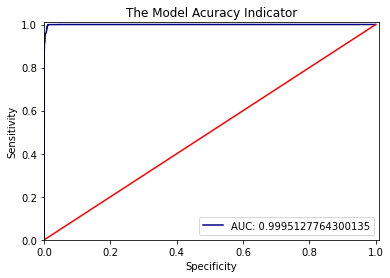

In [59]:
y_predlogreg_proba = d_model.predict_proba(x_testsele_fs)[::,1]
fprlogreg, tprlogreg, _ = roc_curve(y_test,y_predlogreg_proba)
auclogreg = roc_auc_score(y_test, y_predlogreg_proba)
plt.plot(fprlogreg, tprlogreg, label="AUC: "+str(auclogreg), color="navy")
plt.plot([0,1],[0,1],color="red")
plt.xlim([0.00,1.01])
plt.ylim([0.00,1.01])
plt.xlabel("Specificity")
plt.ylabel("Sensitivity")
plt.legend(loc=4)
plt.title('The Model Acuracy Indicator')
plt.show()

## Related Work Implementation (DOI: https://doi.org/10.1007/978-3-030-03302-6_3)
Feed-Forward Backpropagation for Botnet Detection

In [60]:
#Base paper (Feed-Forward Backpropagation for Botnet Detection) 
#Implimentation wich is implimented with 10 hidden layers 
from sklearn.neural_network import MLPClassifier
MLP_model = MLPClassifier(random_state=42, max_iter=120,hidden_layer_sizes=(10,10,10))
MLP_model = MLP_model.fit(x_trainsele_fs, y_train)
pred = MLP_model.predict(x_testsele_fs)
Confusion_matxmlp=pd.DataFrame(confusion_matrix(y_test,pred),index=["Actual Benign","Actual Bot"],
                               columns=("Prediction Benign", "Prediction Bot"))
print(Confusion_matxmlp)
print('----------------------------------------------------------------------')
Acc_statemlp=accuracy_score(y_test,pred)
print('Accuracy of the Model= %.2f '%(Acc_statemlp*100))
print('----------------------------------------------------------------------')

               Prediction Benign  Prediction Bot
Actual Benign              17235             253
Actual Bot                    10            5363
----------------------------------------------------------------------
Accuracy of the Model= 98.85 
----------------------------------------------------------------------


C:\DOSTY\Machine_learning\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (120) reached and the optimization hasn't converged yet.



In [61]:
# performance Analysis of Base Paper
TP,FN,FP,TN=confusion_matrix(list(y_test),list(pred),labels=[0,1]).ravel()
print('TP: ',TP,' FP: ',FP,' FN: ',FN, ' TN: ',TN)
TN_FP=FP+TN
TP_FN=FN+TP
print('TP+FP (total): ',TN_FP)
print('TN+FN (total): ',TP_FN)
print('True Positive Rate: ',TP/TP_FN)
print('True Negative Rate: ',TN/TN_FP)
print('False Positive Rate: ',FP/TN_FP)
print('False Negative Rate: ',FN/TP_FN)

TP:  17235  FP:  10  FN:  253  TN:  5363
TP+FP (total):  5373
TN+FN (total):  17488
True Positive Rate:  0.9855329368709973
True Negative Rate:  0.9981388423599479
False Positive Rate:  0.0018611576400521124
False Negative Rate:  0.014467063129002745


## Related work Implementation (DOI: 10.1109/ICCWS48432.2020.9292395)  
Robust Early Stage Botnet Detection using Machine Learning

In [62]:
# Second base Pepar(Robust Early Stage Botnet Detection using Machine Learning)
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier()
x_testsele_fs_=x_testsele_fs[:,:38]
x_trainsele_fs_=x_trainsele_fs[:,:38]
clf.fit(x_trainsele_fs_, y_train)
y_pred_proba = clf.predict(x_testsele_fs_)
Confusion_matxmlp=pd.DataFrame(confusion_matrix(y_test,y_pred_proba),index=["Actual Benign","Actual Bot"],
                               columns=("Prediction Benign", "Prediction Bot"))
print(Confusion_matxmlp)
print('----------------------------------------------------------------------')
Acc_statemlp=accuracy_score(y_test,y_pred_proba)
print('Accuracy of the Model= %.2f '%(Acc_statemlp*100))
print('----------------------------------------------------------------------')
# performance Analysis of Base Paper
TP,FN,FP,TN=confusion_matrix(list(y_test),list(y_pred_proba),labels=[0,1]).ravel()
print('TP: ',TP,' FP: ',FP,' FN: ',FN, ' TN: ',TN)
TN_FP=FP+TN
TP_FN=FN+TP
print('TP+FP (total): ',TN_FP)
print('TN+FN (total): ',TP_FN)
print('True Positive Rate: ',TP/TP_FN)
print('True Negative Rate: ',TN/TN_FP)
print('False Positive Rate: ',FP/TN_FP)
print('False Negative Rate: ',FN/TP_FN)

               Prediction Benign  Prediction Bot
Actual Benign              17142             346
Actual Bot                    26            5347
----------------------------------------------------------------------
Accuracy of the Model= 98.37 
----------------------------------------------------------------------
TP:  17142  FP:  26  FN:  346  TN:  5347
TP+FP (total):  5373
TN+FN (total):  17488
True Positive Rate:  0.9802150045745655
True Negative Rate:  0.9951609901358645
False Positive Rate:  0.004839009864135492
False Negative Rate:  0.019784995425434583


## Model Validation 
Methods that Validats the current work (thi model) with prime works (MLP and RF)

In [63]:
    if(model==clf_):
        mm=model.predict(x_testsele_fs_)
        DNNM_Analysis = accuracy_score(y_test,mm)
    else:
        mm=model.predict(x_testsele_fs)
        DNNM_Analysis = accuracy_score(y_test,mm)
    names.append(name)
    results.append(DNNM_Analysis*100)
    print(name)
    print('Accuracy of the Model= %.2f '%(DNNM_Analysis*100))
    print()

MLP
Accuracy of the Model= 98.37 

RF
Accuracy of the Model= 98.85 

715/715 [==============================] - 1s 2ms/step
Current_work(DNN)
Accuracy of the Model= 99.10 



In [156]:
df_model={'mname':names, 'mresult':results}
df_dmodel=pd.DataFrame(data=df_model)
bar_con=np.arange(len(names))
labels = ['Bening', 'Botnet','OurWork']
cfs.set_config_file(sharing='Public',theme='polar',offline=True)
benign_bot_status=df_dmodel.set_index('mname')
benign_bot_status.iplot(kind='bar',color='blue',xTitle="Models",yTitle="Accuracy",dimensions=(600,450),
                        title='Result Analysis',bargap=0.2,sortbars=True)


In [ ]:
# model_set = set(df_dmodel['mname'])
# plt.figure()
# for mlc in model_set:
#     selected_data = df_dmodel.loc[df_dmodel['mname'] == mlc]
#     plt.plot(selected_data['mname'], selected_data['mresult'], label=mlc)
# plt.legend()
# plt.show()